This notebook is established with [Reference](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b).

In [1]:
# Import all the required libraries

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import itertools

# time series decomposition
import statsmodels.api as sm

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Import data

In [2]:
df = pd.read_excel("sample_superstore.xls")
df.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   datetime64[ns]
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Category   9994 n

There are several categories in the superstore sales data, we start from time series analysis and forecasting for furniture sales. We have data across 4 years.

In [4]:
furniture = df.loc[df['Category'] == 'Furniture']

In [5]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

# Data Preprocessing
- Remove columns we do not need (only keep `Order Date` and `Sales`)
- Check missing values
- Aggregate sales by date
- Reindex with Order Date

In [6]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 
        'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)

In [7]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [8]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current data is aggregated to single days, which can be tricky to work with because the dates are not successive. Instead, we resample the data to monthly and use average daily sales for each month. We use the start of each month as the timestamp.

In [9]:
furniture = furniture['Sales'].resample('MS').mean()

# Train-test split

In [28]:
train = furniture[:pd.to_datetime('2017-06-01')]
test = furniture[pd.to_datetime('2017-07-01'):]
print(train.index)
print(test.index)

DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01'],
              dtype='datetime64[ns]', name='Order Date', freq='MS')
DatetimeIndex(['2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', name='Order Date', freq='

# Visualizing Furniture Sales Time Series Data

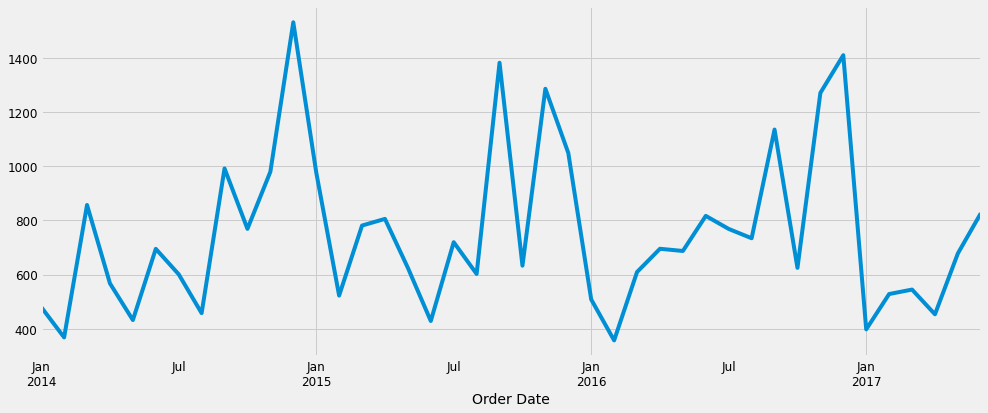

In [29]:
train.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always an upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a time series decomposition that allows us to decompose our time series into four distinct components: level, trend, seasonality, and noise.

A time series can be broke into Systematic Components that have consistency or recurrence and can be described and modeled and Non-Systematic Components that cannot be directly modeled.

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:
- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

[Reference](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

We can visualise our data using time series decomposition.

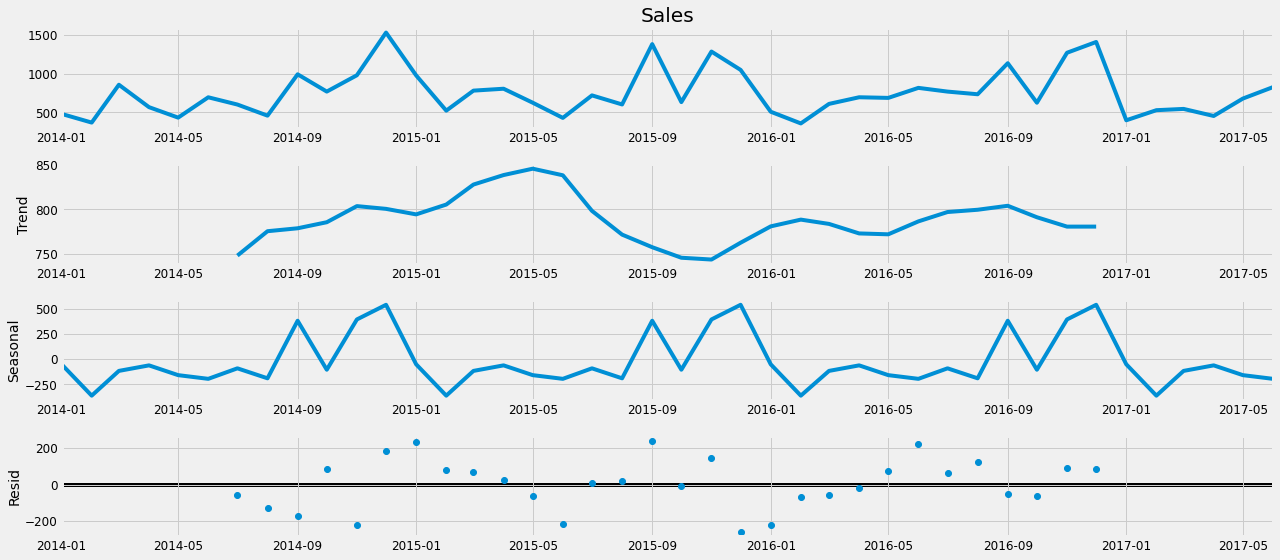

In [30]:
# set figure size
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

# time series decompose
# statsmodels.tsa is a module within the StatsModels library in Python, which stands for "Time Series Analysis."
# StatsModels provides utilities for plotting time series data, decomposing time series into trend, seasonal, and residual components
# and performing statistical tests for stationarity and autocorrelation.
decomposition = sm.tsa.seasonal_decompose(train, model='additive')

# plot
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

# Time series forecasting with SARIMA (Seasonal Autoregressive Integrated Moving Average)

In the context of ARIMA (Autoregressive Integrated Moving Average) models, the parameters $p$, $d$, and $q$ represent the orders of autoregression, differencing, and moving average, respectively.

1. $p$ (Autoregressive Order): This parameter represents the number of lag observations included in the model. It indicates the number of previous time steps to consider for predicting the current value. A higher $p$ value means the model will consider more past observations.

2. $d$ (Differencing Order): This parameter represents the degree of differencing. It is the number of times the raw observations are differenced (i.e., subtracting an observation from the observation at the previous time step). Differencing is used to make the time series stationary, which is often necessary for modeling with ARIMA. A stationary time series has constant mean, variance, and autocorrelation over time.

3. $q$ (Moving Average Order): This parameter represents the size of the moving average window, i.e., the number of lag terms to include in the moving average part of the model. Each term represents the error of the model as a linear combination of error terms from previous observations. A higher $q$ value means the model will consider more past forecast errors.

1. **ARIMA (AutoRegressive Integrated Moving Average)**:
   - ARIMA models are a class of models that include autoregressive (AR), differencing (I), and moving average (MA) components.
   - The ARIMA model is specified by three main parameters: $p$, $d$, and $q$, which correspond to the autoregressive order, differencing order, and moving average order, respectively.
   - ARIMA models are suitable for non-seasonal time series data.

2. **SARIMA (Seasonal AutoRegressive Integrated Moving Average)**:
   - SARIMA models extend ARIMA models to account for seasonality in the time series data.
   - In addition to the parameters $p$, $d$, and $q$ for the non-seasonal components, SARIMA models include additional seasonal parameters: $P$, $D$, $Q$, and $s$, where $P$, $D$, and $Q$ are the seasonal autoregressive, differencing, and moving average orders, respectively, and $s$ is the length of the seasonal cycle (e.g., 12 for monthly data).
   - SARIMA models are suitable for time series data that exhibit seasonal patterns.

3. **SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables)**:
   - SARIMAX models are an extension of SARIMA models that allow for the inclusion of exogenous variables, which are external factors that can influence the time series data.

In [31]:
# Set up parameter combinations for a SARIMA model.
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q)) #itertools.product computes the Cartesian product of input iterables
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq] #the data is monthly and exhibits yearly seasonality, s would typically be 12.

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Then, we perform a grid search over the parameter combinations generated earlier (pdq for non-seasonal parameters and seasonal_pdq for seasonal parameters) to fit SARIMA models to a the 4-year furniture sales time series data.

In [32]:
import warnings
warnings.filterwarnings("ignore")
aic = {'param':[], 'param_seasonal':[], 'AIC':[]}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param, #(p, d, q)
                                            seasonal_order=param_seasonal, #(p, d, q, s)
                                            enforce_stationarity=False, #mean, variance, and autocorrelation structure do not change over time
                                            enforce_invertibility=False) #past values of the series can be expressed as a linear combination of past error terms
            train_result = mod.fit(disp=False)
            aic['param'].append(param)
            aic['param_seasonal'].append(param_seasonal)
            aic['AIC'].append(train_result.aic)
            #Lower AIC values indicate a better trade-off between goodness of fit and model complexity
        except:
            continue
idx = aic['AIC'].index(min(aic['AIC']))
print('The model SARIMAX{}x{} has the lowest AIC value of {}'.format(aic['param'][idx], aic['param_seasonal'][idx], aic['AIC'][idx]))

The model SARIMAX(0, 1, 1)x(0, 1, 1, 12) has the lowest AIC value of 202.499342035798


# Fitting the SARIMAX model

In [33]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(disp=False)
# results.summary()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0278      0.366     -0.076      0.939      -0.746       0.690
ma.L1         -1.0000      0.489     -2.044      0.041      -1.959      -0.041
ma.S.L12      -0.2819      0.186     -1.512      0.131      -0.647       0.084
sigma2      2.667e+04   1.84e-05   1.45e+09      0.000    2.67e+04    2.67e+04


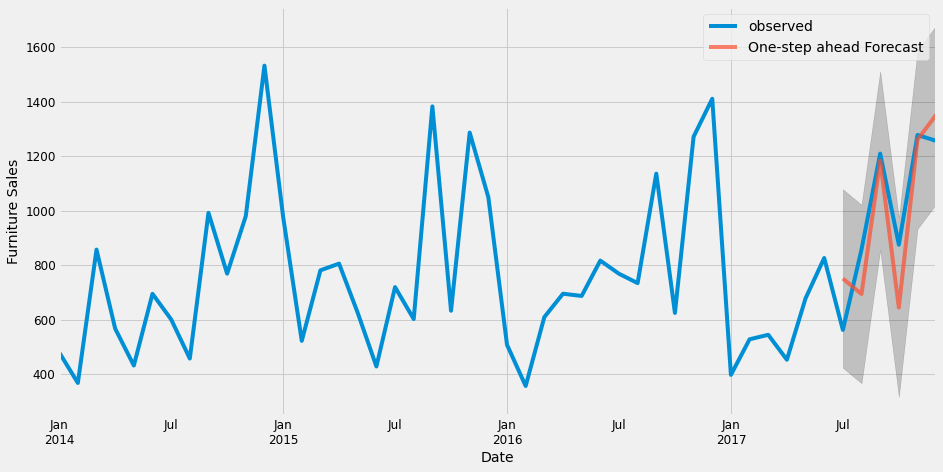

In [34]:
# pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred = results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred_ci = pred.conf_int()
ax = furniture['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()